# Влияние витамина C на рост зубов морских свинок
В эксперименте изучалось влияние витамина C на рост [одонтобластов](https://en.wikipedia.org/wiki/Odontoblast) морских свинок.



Рассматривалось три дозы витамина (0.5, 1 и 2 мг) и два способа его приёма (апельсиновый сок и в чистом виде (== аскорбиновая кислота)). В каждой из 6 групп по уровням двух факторов были произведены измерения для 10 морских свинок.

## Загрузим данные и посмотрим на них

In [88]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import pandas as pd
import seaborn as sns

In [89]:
data = pd.read_csv('ToothGrowth.csv')
data.head()

,Unnamed: 0,len,supp,dose
0,1,4.2,VC,0.5
1,2,11.5,VC,0.5
2,3,7.3,VC,0.5
3,4,5.8,VC,0.5
4,5,6.4,VC,0.5


In [90]:
data = data.drop(columns='Unnamed: 0')
data.head()

,len,supp,dose
0,4.2,VC,0.5
1,11.5,VC,0.5
2,7.3,VC,0.5
3,5.8,VC,0.5
4,6.4,VC,0.5


In [91]:
data.supp.unique()

array(['VC', 'OJ'], dtype=object)

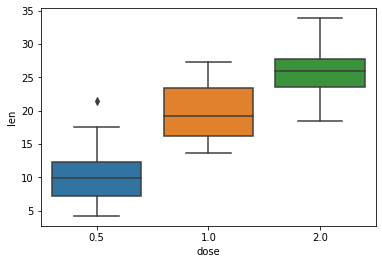

In [92]:
_ = sns.boxplot(x='dose', y='len', data=data)

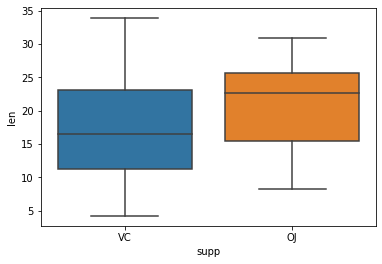

In [93]:
_ = sns.boxplot(x='supp', y='len', data=data)

## Двухфакторный дисперсионный анализ

In [94]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Без учета межфакторного взаимодействия:

In [95]:
lm = ols('len ~ C(supp) + C(dose)',data=data).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(supp),1.0,205.350000,205.350000,14.016638,4.292793e-04
C(dose),2.0,2426.434333,1213.217167,82.810935,1.871163e-17
Residual,56.0,820.425000,14.650446,NaN,NaN


С учетом межфакторного взаимодействия:

In [96]:
lm = ols('len ~ C(supp) * C(dose)', data=data).fit()
table = sm.stats.anova_lm(lm, typ=1)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(supp),1.0,205.350000,205.350000,15.571979,2.311828e-04
C(dose),2.0,2426.434333,1213.217167,91.999965,4.046291e-18
C(supp):C(dose),2.0,108.319000,54.159500,4.106991,2.186027e-02
Residual,54.0,712.106000,13.187148,NaN,NaN


### Межфакторное взаимодействие:

$$X_{ijk} = \mu + \alpha_i + \beta_j + \gamma_{ij} + \varepsilon_{ijk},$$
$$i = 1, ..., K_1,\ j = 1, ..., K_2,\ k = 1, ..., n.$$

- $\mu$ -- общее среднее значение признака,
- $\alpha_i$ -- воздействие уровня $i$ фактора $f_1$,
- $\beta_j$ -- воздействие уровня $j$ фактора $f_2$,
- $\gamma_{ij}$ -- дополнительное воздействие комбинации уровней $i$ и $j$ факторов $f_1$ и $f_2$,
- $\varepsilon_{ijk}$ -- случайные независимые одинаково распределенные ошибки

`sns.pointplot`: 
- точки -- средние значения исследуемого параметра по каждой из групп (значению категориальной переменной)
- 95%-й доверительный интервал

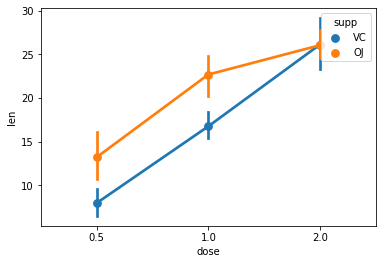

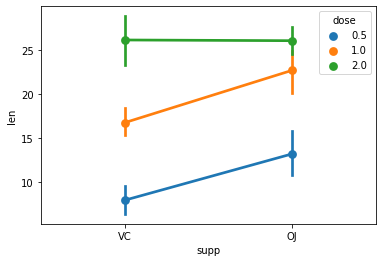

In [97]:
_ = sns.pointplot(x="dose", y="len", data=data, hue='supp')
plt.show()
_ = sns.pointplot(x="supp", y="len", data=data, hue='dose')

Взаимодействие между факторами можно наблюдать, когда результат от воздействия одного фактора на зависимую переменную не одинаков при разных значениях другого фактора.

## Взаимодействие значимо, поэтому разделим выборку по способу приёма витамина.

In [98]:
OJ = data[data['supp']=='OJ']
VC = data[data['supp']=='VC']
VC.shape, OJ.shape

((30, 3), (30, 3))

### Для морских свинок, принимающих аскорбиновую кислоту:

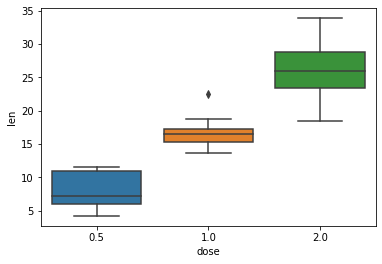

In [99]:
_ = sns.boxplot(x='dose', y='len', data=VC)

In [100]:
lm = ols('len ~ C(dose)',data=VC).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(dose),2.0,1649.488667,824.744333,67.072379,3.357317e-11
Residual,27.0,332.001000,12.296333,NaN,NaN


Для морских свинок, принимающих аскорбиновую кислоту влияние разных уровней фактора дозы неодинаково

#### Критерий Краскела-Уоллиса о равенстве средних всех групп

In [101]:
st.kruskal(*VC.groupby('dose').groups.values())

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)

#### Исследуем попарные различия в воздействии на целевой признак между всеми уровнями фактора дозы

In [102]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(VC['len'], VC['dose'])
result = mc.tukeyhsd()
 
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   0.5    1.0     8.79 0.001  4.9025 12.6775   True
   0.5    2.0    18.16 0.001 14.2725 22.0475   True
   1.0    2.0     9.37 0.001  5.4825 13.2575   True
---------------------------------------------------


Значимые различия во влиянии на целевую переменную есть между каждой парой групп

### Для морских свинок, принимающих апельсиновый сок:

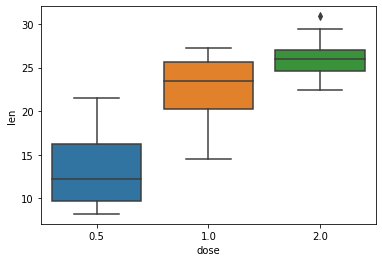

In [103]:
_ = sns.boxplot(x='dose', y='len', data=OJ)

In [104]:
lm = ols('len ~ C(dose)',data=OJ).fit()
table = sm.stats.anova_lm(lm)
table

,df,sum_sq,mean_sq,F,PR(>F)
C(dose),2.0,885.264667,442.632333,31.441504,8.887164e-08
Residual,27.0,380.105000,14.077963,NaN,NaN


Отвергаем гипотезу о том, что каждый уровень фактора дозы вносит одинаковый вклад в целевую переменную

#### Исследуем попарные различия в воздействии на целевой признак между всеми уровнями фактора дозы

In [105]:
mc = MultiComparison(OJ['len'], OJ['dose'])
result = mc.tukeyhsd()
 
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   0.5    1.0     9.47  0.001  5.3104 13.6296   True
   0.5    2.0    12.83  0.001  8.6704 16.9896   True
   1.0    2.0     3.36 0.1308 -0.7996  7.5196  False
----------------------------------------------------


Значимые отличия в воздействии на целевой признак отсутствуют только между 1 и 2

Text(0.5, 1.0, 'Pointplot for orange juice')

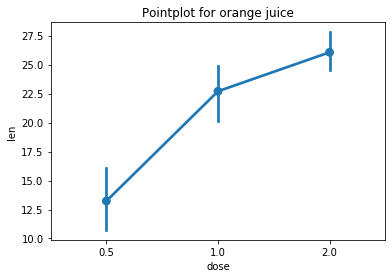

In [106]:
_ = sns.pointplot(x="dose", y="len", data=OJ)
plt.title('Pointplot for orange juice')

## Итого

- для морских свинок, принимающих аскорбиновую кислоту, различия между размером дозы значимы всегда
- для морских свинок, принимающих апельсиновый сок, различия между размером дозы в 1 и 2 мг не значимо

**Crampton E. W. (1947) The growth of the odontoblast of the incisor teeth as a criterion of vitamin C intake of the guinea pig. The Journal of Nutrition 33(5): 491–504.**